# ESP32 + LD2410: TensorFlow RNN for classification of movements
### Подготовил: Степанюк Денис Борисович

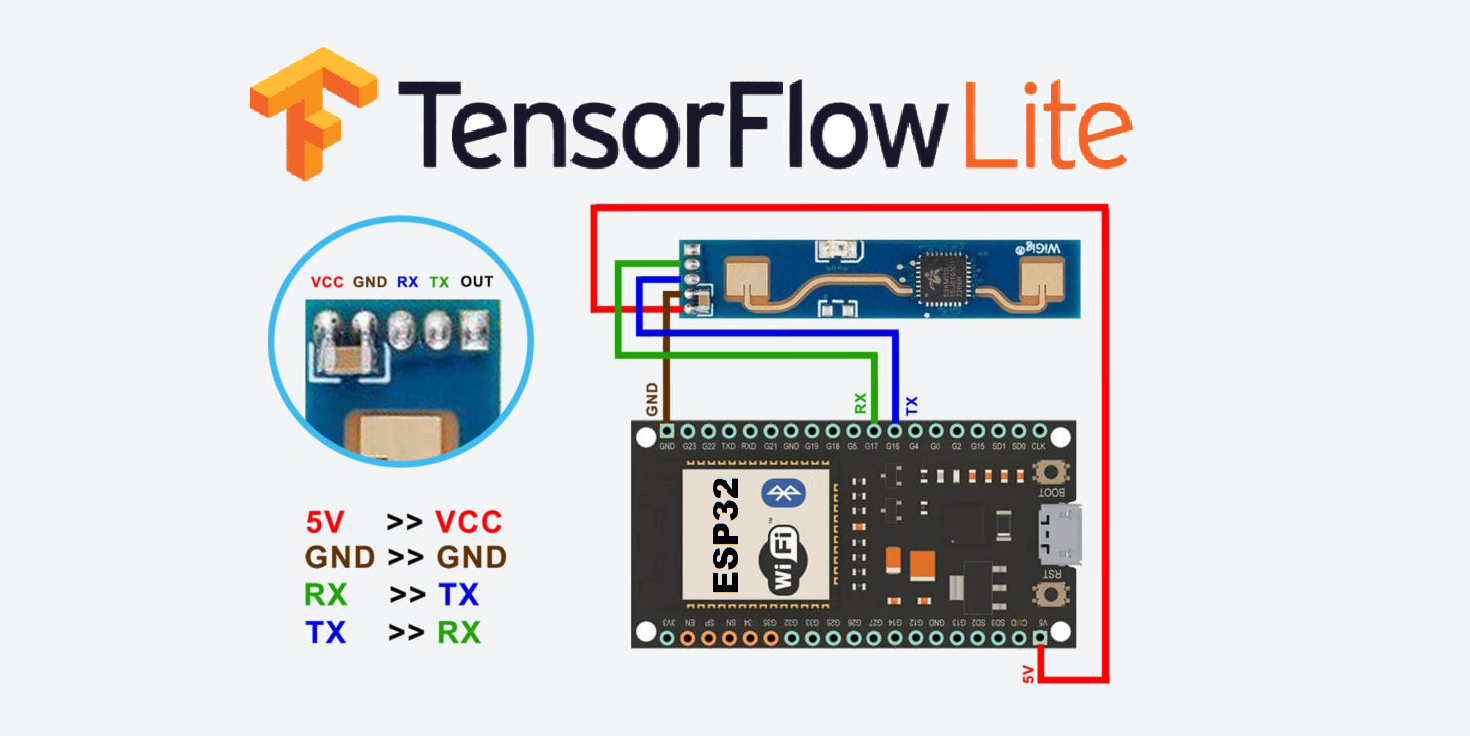
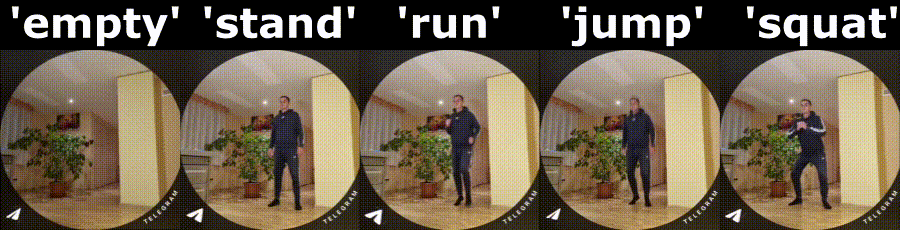

### Структура датафрейма

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Столбцы числовых признаков.
num_cols = [
    ' MOVE_1',
    ' MOVE_2',
    ' MOVE_3',
    ' MOVE_4',
    ' MOVE_5',
    ' MOVE_6',
    ' MOVE_7',
    ' MOVE_8',
    ' MOVE_9',
    ' STAT_1',
    ' STAT_2',
    ' STAT_3',
    ' STAT_4',
    ' STAT_5',
    ' STAT_6',
    ' STAT_7',
    ' STAT_8',
    ' STAT_9'
]

# Столбец предсказываемого категориального признака.
target_col = 'CATEGORY'

# Предсказываемые категории.
categories = ['empty', 'stand', 'run', 'jump', 'squat']

# Кол-во предсказываемых категорий.
cat_num = len(categories)

# Загрузка данных

In [2]:
import os

# путь к папке
folder_path = './Dataset'

# собираем список всех CSV файлов
files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# читаем все CSV и складываем в список
dataframes = [pd.read_csv(os.path.join(folder_path, f)) for f in files]

# объединяем в один DataFrame
data_all = pd.concat(dataframes, ignore_index=True)

data_all.head()

CATEGORY   MOVE_1   MOVE_2   MOVE_3   MOVE_4   MOVE_5   MOVE_6   MOVE_7  \
0    stand       33       26       43       37       11        4        8   
1    stand       31       23       58       51        6       10        6   
2    stand       34       27       57       45        4        7       10   
3    stand       39       28       10       16       15       12        5   
4    stand       38       33       48       22       20       11       10   

    MOVE_8   MOVE_9  ...   STAT_2   STAT_3   STAT_4   STAT_5   STAT_6  \
0        6        4  ...        0      100      100      100       73   
1        8        4  ...        0      100      100      100       69   
2       12       10  ...        0      100      100      100       66   
3        4        9  ...        0      100      100      100       62   
4        4        4  ...        0      100      100      100       70   

    STAT_7   STAT_8   STAT_9    TIME   ID   
0       55       38       25  792656     1  
1       88      100      100  594766     2  
2       63       87       75  595823     3  
3       60       84       65  596919     4  
4       64       80       58  597979     5  

[5 rows x 21 columns]

# Визуализация данных
### График изменения состояния гейтов во времени

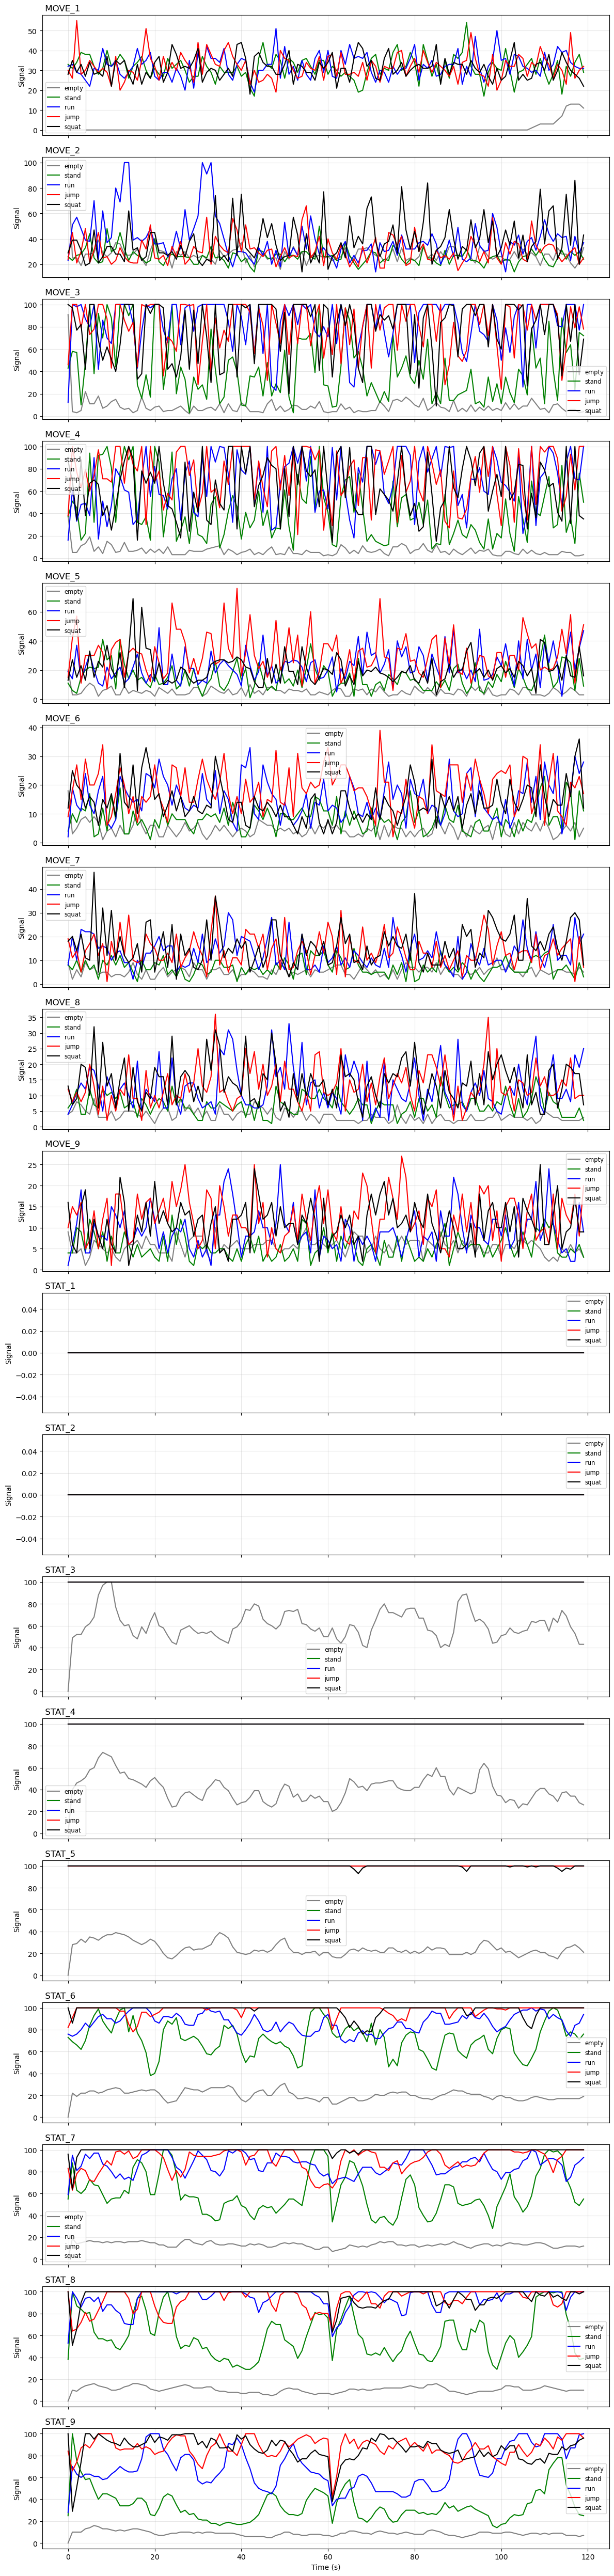

In [3]:
# Цвета для категорий (5 категорий = 5 цветов)
colors = ['gray', 'green', 'blue', 'red', 'black']

# 18 осей (по числу столбцов в num_cols)
fig, ax_list = plt.subplots(18, 1, figsize=(12, 50), sharex=True)

# Если ax_list одномерный массив — итерируемся по нему напрямую
for column, ax in zip(num_cols, ax_list):
    for color, cat in zip(colors, categories):
        # Берём первые 60 наблюдений для категории
        series = (data_all.loc[data_all['CATEGORY'] == cat, column]
                          .dropna()
                          .head(120))
        if series.empty:
            continue

        # Временная ось: по секундам (0..n-1)
        x = np.arange(len(series))
        ax.plot(x, series.values, label=cat, color=color)

    ax.set_title(column, loc='left')
    ax.set_ylabel('Signal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize='small')

# Общая подпись оси X только внизу
ax_list[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Подготовка данных
### Делим набор данных на тренировочный и валидационный

In [4]:
# Список для набора тренировочных данных.
train_dataframe = []
# Список для набора валидационных данных.
test_dataframe = []

# Итерируемся по предсказываемым категорияим.
for c in categories:
    # Добавлеяи в набор тренировочных данных экземпляры данных для текущей категории (все кроме 50 последних).
    train_dataframe.append(data_all[data_all['CATEGORY'] == c][[target_col] + num_cols][:-50])
    # Добавлеяи в набор валидационных данных экземпляры данных для текущей категории (50 последних экземпляров).
    test_dataframe.append(data_all[data_all['CATEGORY'] == c][[target_col] + num_cols][-50:])

# Преобразуем списки в датафреймы.
train_dataframe = pd.concat(train_dataframe, ignore_index=True)
test_dataframe = pd.concat(test_dataframe, ignore_index=True)

### Формируем из данных входы для модели

In [5]:
# Кол-во экземпляров данных формирующих один батч.
step = 10

# Набор тренировочных данных.
X_train = []
# Набор предсказываемых категорий для тренировочных данных.
Y_train_labels = []

# Набор валидационных данных.
X_test = []
# Набор предсказываемых категорий для валидационных данных.
Y_test_labels = []

# Итерируемся по предсказываемым категорияим.
for c in categories:
    # Кол-во экземпляров данных в тренировочном наборе.
    category_train_len = len(train_dataframe[train_dataframe['CATEGORY'] == c])
    # Получим массив входов (единичных батчей 10х18) для тренировочного набора данных.
    for i in range(category_train_len):
        if(i + step < category_train_len):
            Y_train_labels.append(c)
            X_train.append(train_dataframe[train_dataframe['CATEGORY'] == c][num_cols][i:i+step].to_numpy())
        else:
            continue
    # Кол-во экземпляров данных в валидационном наборе.
    category_test_len = len(test_dataframe[test_dataframe['CATEGORY'] == c])
    # Получим массив входов (единичных батчей 10х18) для валидационного набора данных.
    for i in range(category_test_len):
        if(i + step < category_test_len):
            Y_test_labels.append(c)
            X_test.append(test_dataframe[test_dataframe['CATEGORY'] == c][num_cols][i:i+step].to_numpy())
        else:
            continue

# Набор тренировочных данных.
X_train = np.array(X_train)
# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_train = pd.get_dummies(Y_train_labels)

# Набор валидационных данных.
X_test = np.array(X_test)
# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_test = pd.get_dummies(Y_test_labels)

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(900, 10, 18)
(900, 5)
(200, 10, 18)
(200, 5)


### Рандомно перемешаем тренировочные данные

In [7]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части.
X1, X2, Y1, Y2 = train_test_split(X_train, Y_train, train_size = 0.5)

# Обьеденим две части датасета.
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

print(X.shape)
print(Y.shape)

(900, 10, 18)
(900, 5)


# Отобразим псевдоизображения

In [8]:
# Функции для отображения псевдоизображений с радара.
def imshow(X, Y, el, plt_ax):
    """Imshow для тензоров"""
    if plt_ax is None: # создаём фигуру и ось, если не передана
        fig, plt_ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 18), sharey=True, sharex=True)
    plt_ax.imshow(X[el]) # показываем картинку
    plt_ax.set_title(Y[el], fontsize=44) # подпись – правильный класс
    plt_ax.axis("off")  # убираем оси для красоты


def five_categories_view_plt(X, Y, pcs):
    nrows, ncols = pcs, 5
    fig, ax = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(ncols * 18, nrows * 10),  # размер полотна под каждую картинку
        sharey=True, sharex=True
    )

    indices = []
    # находим индексы изображений для каждой категории
    for c in categories:
        indices.append([i for i, x in enumerate(Y_train_labels) if x == c][:pcs])
        
    # проходим по сетке и рисуем изображения
    for i in range(nrows):      # строки (pcs)
        for j in range(ncols):  # столбцы (5)
            try:
                imshow(X, Y, indices[j][i], plt_ax=ax[i, j])
            except IndexError:
                ax[i, j].axis("off")  # если данных не хватило

    plt.tight_layout()
    plt.show()

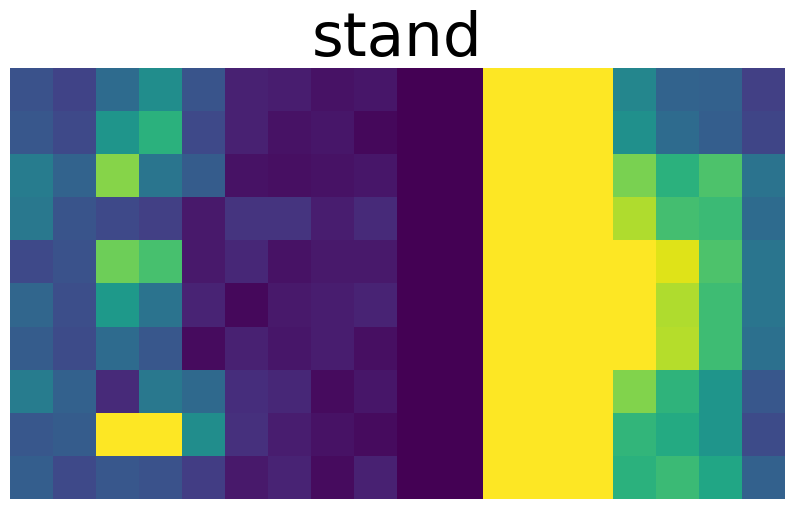

In [9]:
# Отобразим одно псевдоизображение.
imshow(X_train, Y_train_labels, 359, None)

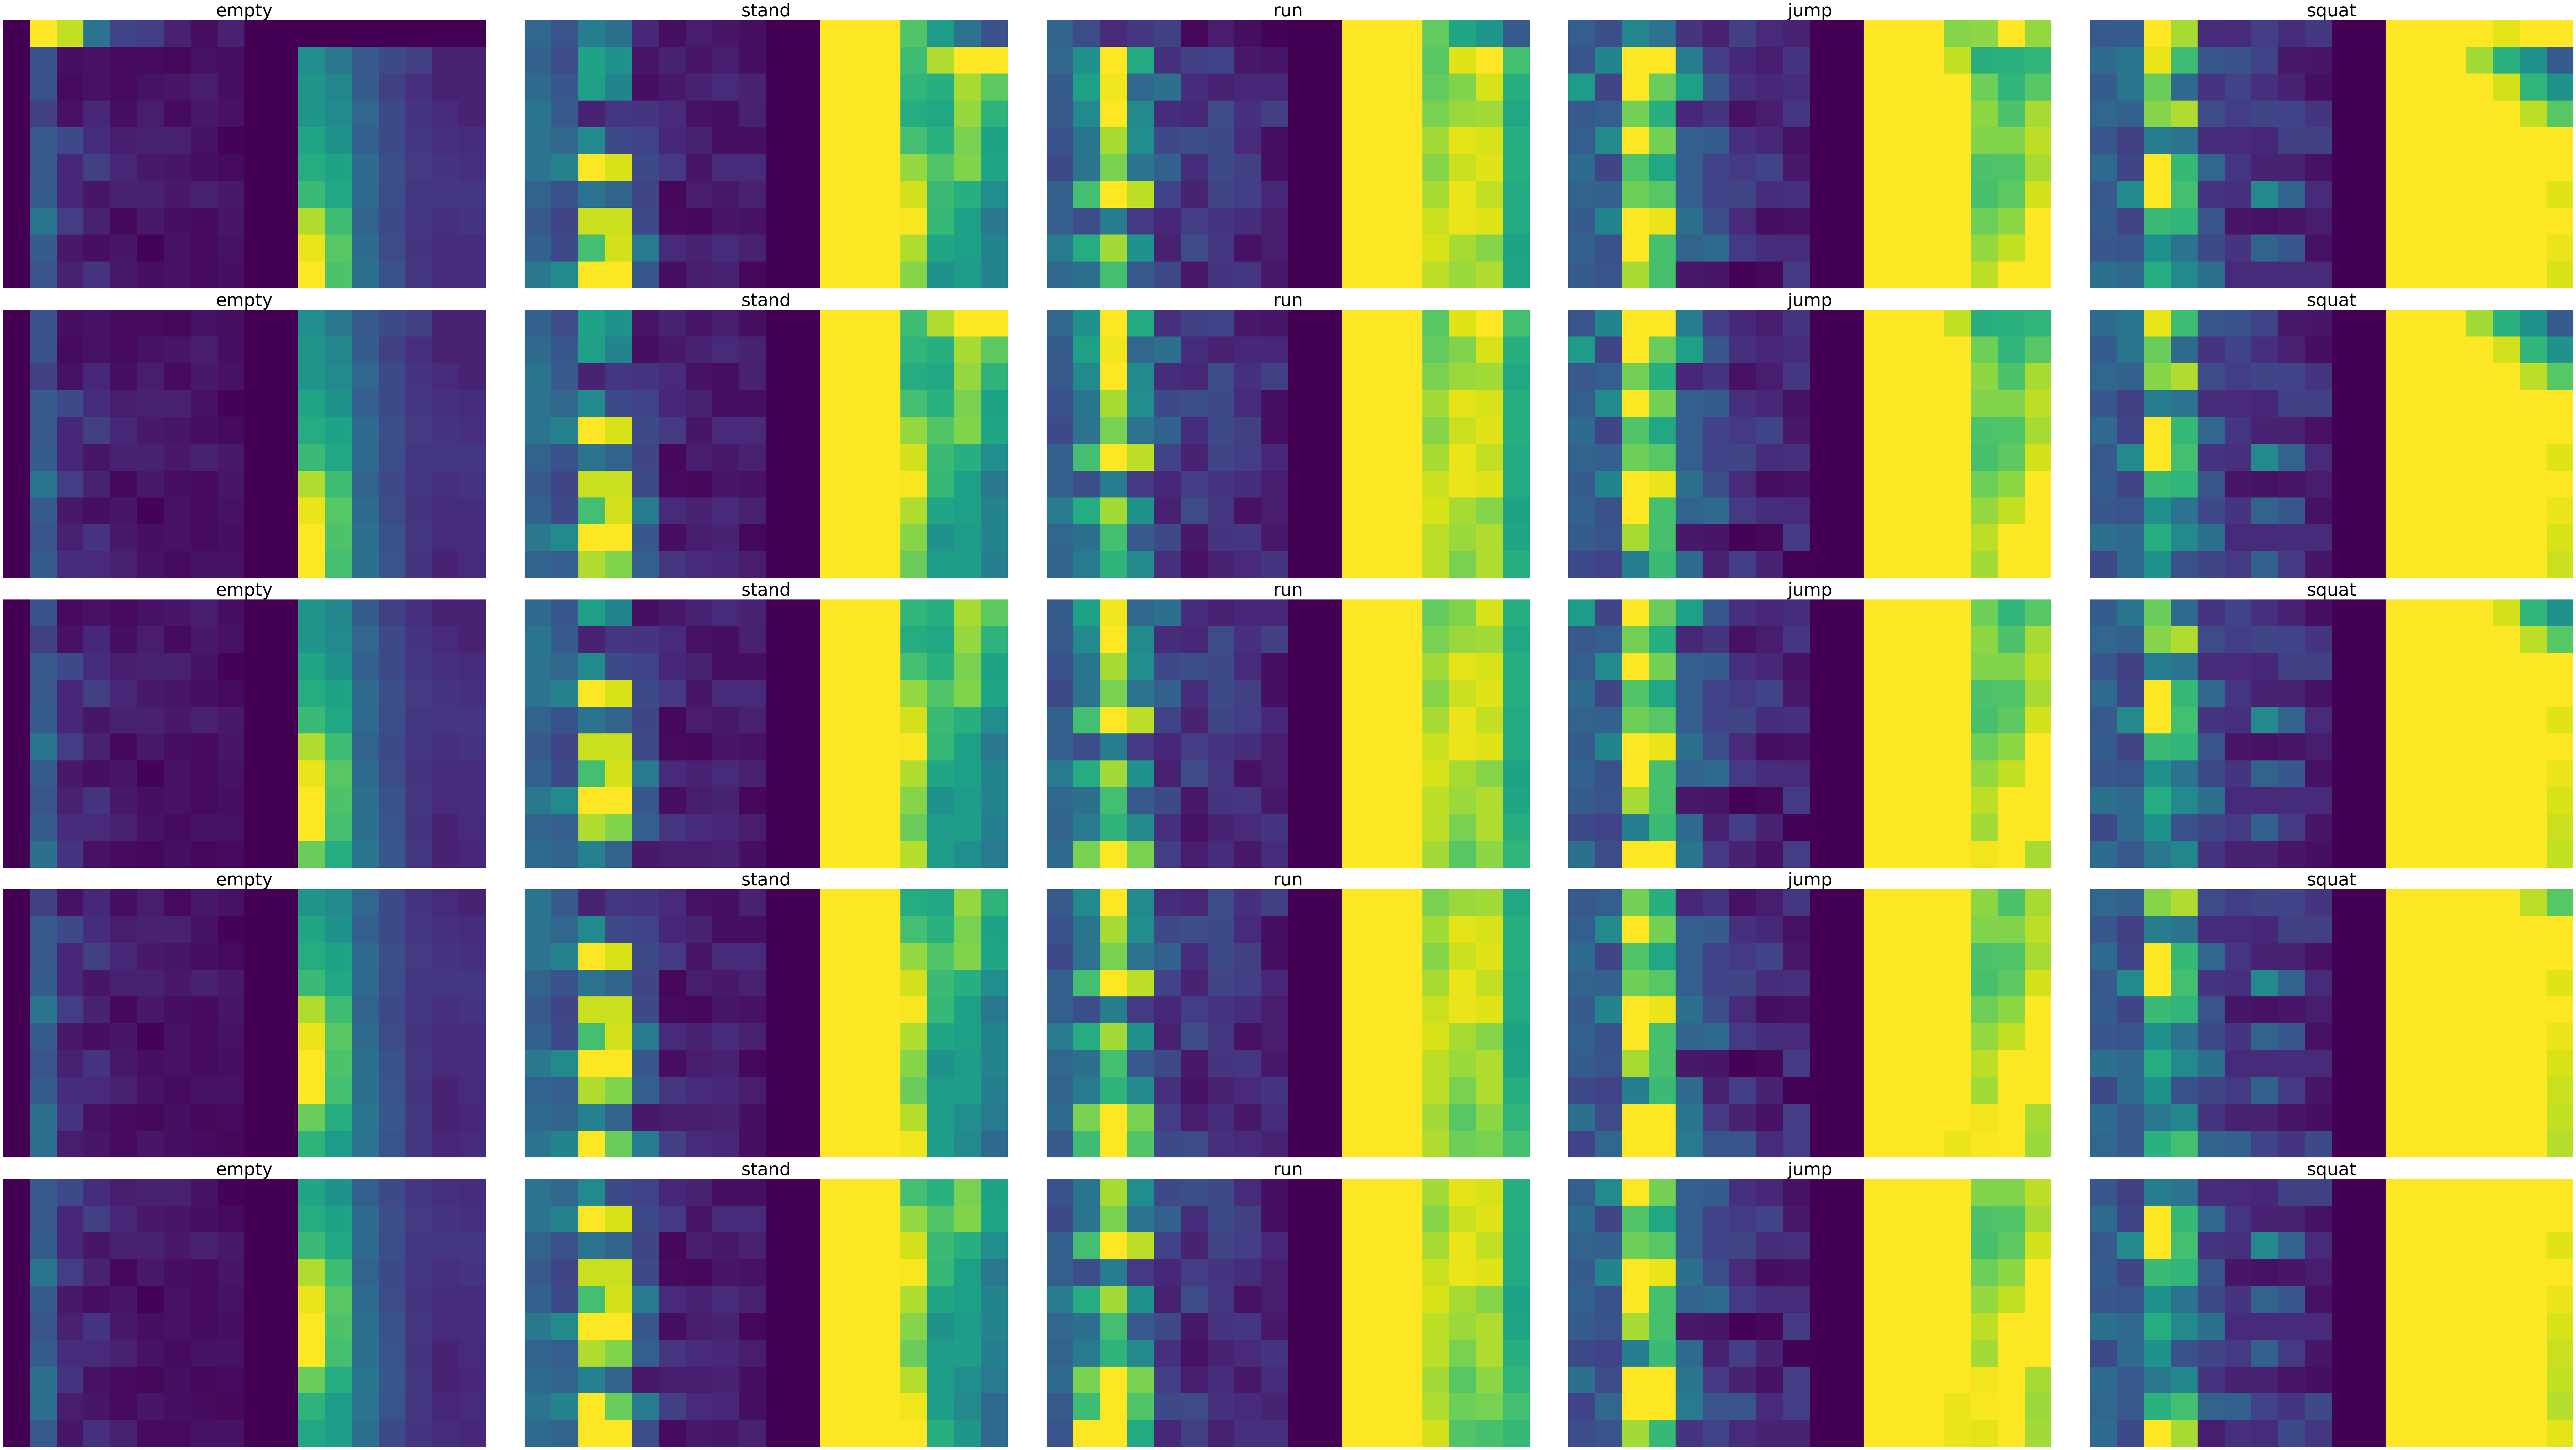

In [10]:
# Отобразим по 5 псевдоизображений для каждой предсказываемой категории.
five_categories_view_plt(X_train, Y_train_labels, 5)

# РЕКУРРЕНТНЫЕ НЕЙРОННЫЕ СЕТИ

**Рекуррентная нейронная сеть — это особый тип нейросети, которая предназначена для работы с последовательными данными, такими как текст, речь или временные ряды. В отличие от обычных сетей, RNN учитывает не только текущий вход, но и контекст из предыдущих шагов.**

* **Каждый шаг сети принимает входные данные и скрытое состояние, содержащее информацию о предыдущих шагах.**

* **Сеть обновляет скрытое состояние, что позволяет ей запоминать последовательность событий.**

* **Это делает RNN особенно полезными для задач обработки естественного языка, распознавания речи и анализа временных рядов.**

* **Главная особенность рекуррентных сетей — наличие “памяти”, которая хранит информацию о прошлых шагах и помогает точнее интерпретировать текущие данные.**

https://www.tensorflow.org/guide/keras/working_with_rnns
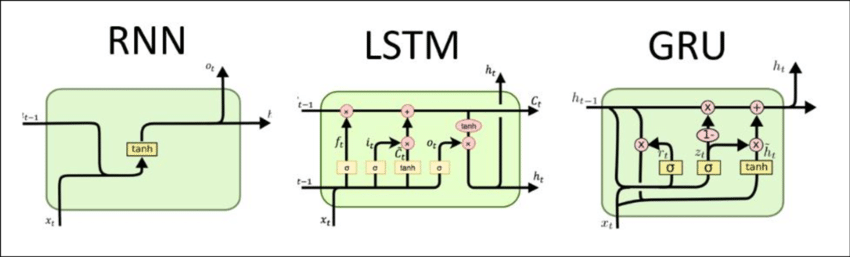

In [11]:
# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [12]:
# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

# RNN модель:
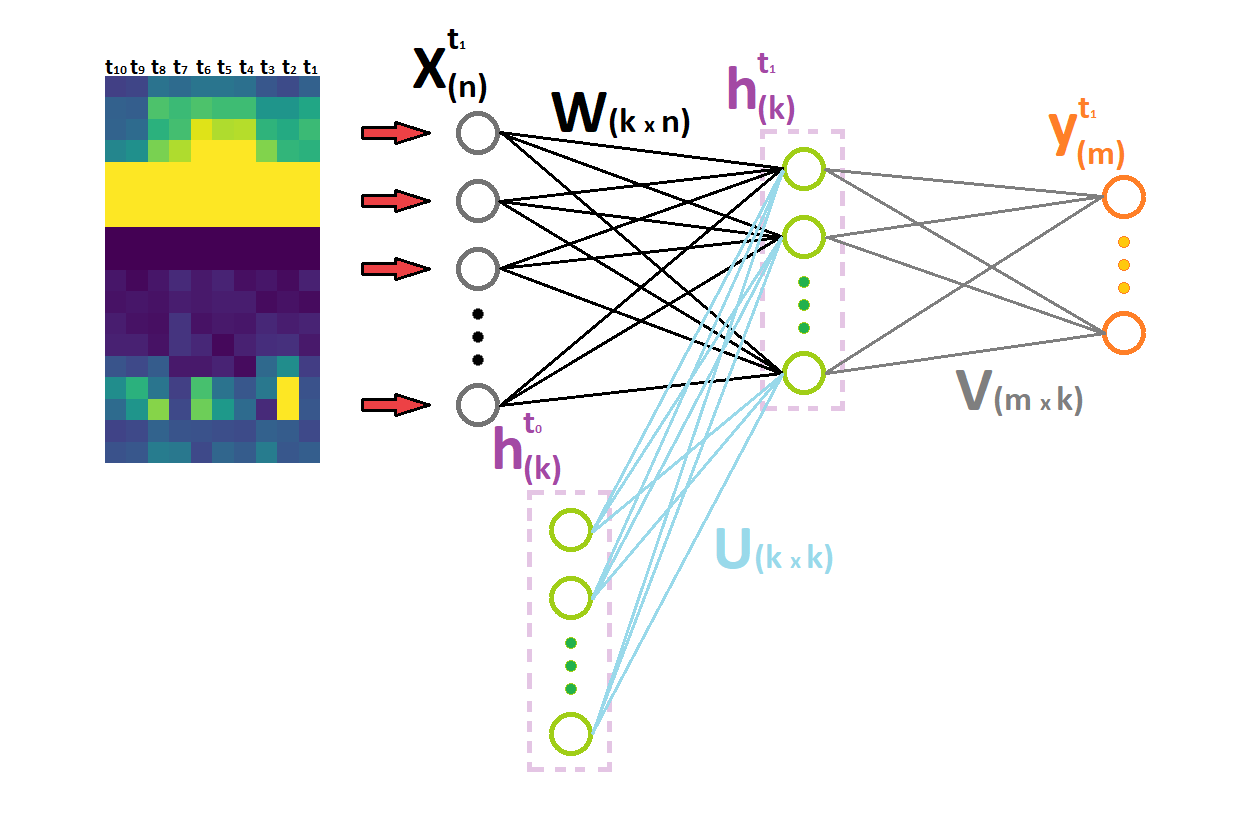

In [30]:
timesteps = 10   # длина последовательности.
features = 18    # число признаков во входном векторе.

# Инициализация модели.
model_RNN = keras.Sequential()

# Рекуррентный слой.
model_RNN.add(layers.SimpleRNN(64, input_shape=(timesteps, features)))
# Выходной (предсказывающий) линейный слой.
model_RNN.add(layers.Dense(cat_num, activation="softmax"))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                5312      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 5637 (22.02 KB)
Trainable params: 5637 (22.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Кол-во итераций обучения.
Epochs = 100

# Запустить обучение модели.
history_RNN = model_RNN.fit(x = X, # Признаки на которых будем предсказывать цвет.
                        y = Y, # Правильные ответы.
                        epochs = Epochs, # Кол-во итераций обучения.
                        validation_data = (X_test, Y_test), # Валидационные данные.
                        callbacks = [learning_rate_reduction]) # Динамическая настройка скорости обучения.

# Сохранить модель.
model_RNN.save('model_RNN.h5')

Epoch 1/100
29/29 [==============================] - 1s 6ms/step - loss: 1.5289 - accuracy: 0.3833 - val_loss: 1.1948 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 1.1008 - accuracy: 0.5444 - val_loss: 1.0248 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9796 - accuracy: 0.5711 - val_loss: 0.9376 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9227 - accuracy: 0.6067 - val_loss: 0.9011 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8554 - accuracy: 0.6100 - val_loss: 0.8189 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8144 - accuracy: 0.6644 - val_loss: 0.8093 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 0.7

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_RNN.evaluate(X_test, Y_test)[1]*100 , "%")

7/7 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9450
Accuracy of the model is -  94.49999928474426 %


### Анализ процесса обучения модели

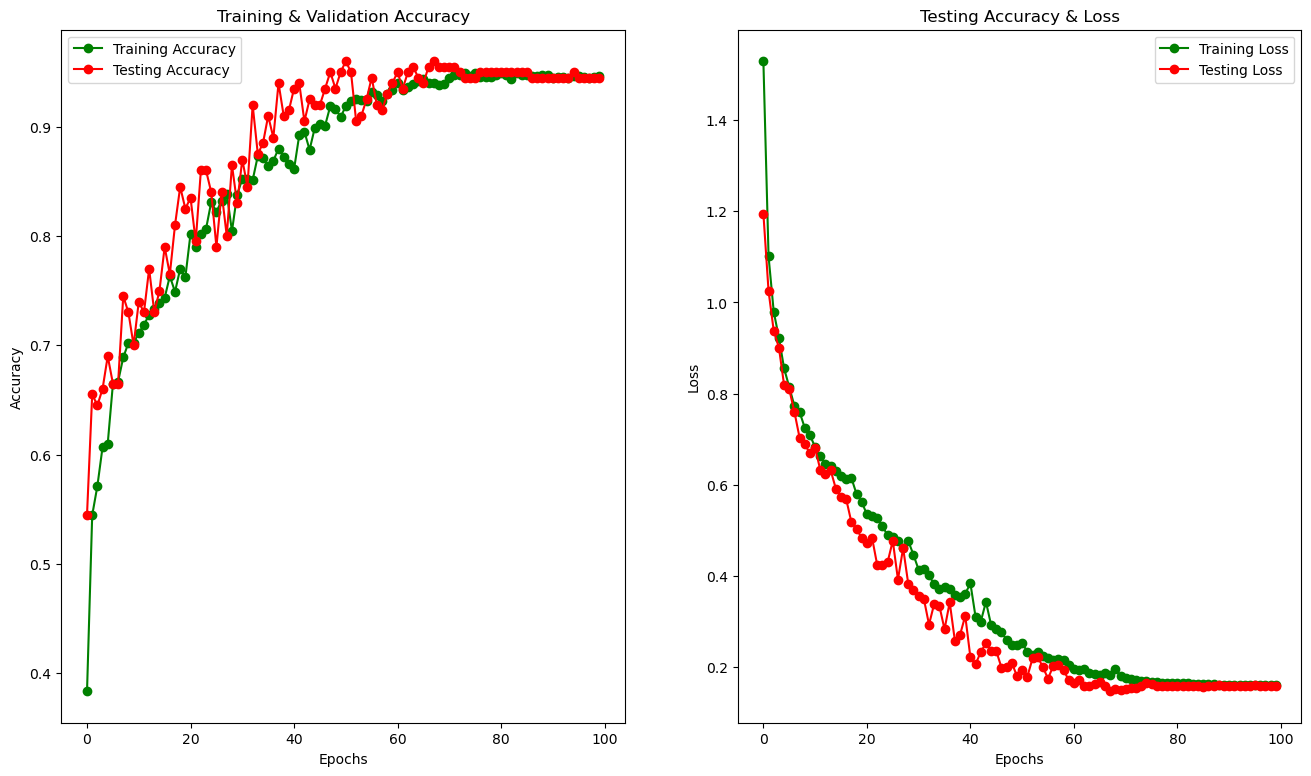

In [33]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history_RNN.history['accuracy']
train_loss = history_RNN.history['loss']
val_acc = history_RNN.history['val_accuracy']
val_loss = history_RNN.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [34]:
for var in model_RNN.trainable_weights:
    print(f"{var.name} | shape={var.shape}")
    #for v in var:
        #print(v)

simple_rnn_1/simple_rnn_cell/kernel:0 | shape=(18, 64)
simple_rnn_1/simple_rnn_cell/recurrent_kernel:0 | shape=(64, 64)
simple_rnn_1/simple_rnn_cell/bias:0 | shape=(64,)
dense_3/kernel:0 | shape=(64, 5)
dense_3/bias:0 | shape=(5,)


# GRU модель:

In [18]:
# Инициализация модели.
model_GRU = keras.Sequential()

# Рекуррентный слой.
model_GRU.add(layers.GRU(128, input_shape=(timesteps, features)))
# Выходной (предсказывающий) линейный слой.
model_GRU.add(layers.Dense(cat_num, activation="softmax"))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               56832     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 57477 (224.52 KB)
Trainable params: 57477 (224.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Кол-во итераций обучения.
Epochs = 60

# Запустить обучение модели.
history_GRU = model_GRU.fit(x = X, # Признаки на которых будем предсказывать цвет.
                            y = Y, # Правильные ответы.
                            epochs = Epochs, # Кол-во итераций обучения.
                            validation_data = (X_test, Y_test), # Валидационные данные.
                            callbacks = [learning_rate_reduction])

# Сохранить модель.
model_GRU.save('model_GRU.h5')

Epoch 1/60
29/29 [==============================] - 1s 12ms/step - loss: 1.1860 - accuracy: 0.5044 - val_loss: 0.8008 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 2/60
29/29 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.7767 - val_loss: 0.6084 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/60
29/29 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.8644 - val_loss: 0.5458 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 4/60
29/29 [==============================] - 0s 4ms/step - loss: 0.4263 - accuracy: 0.8956 - val_loss: 0.4785 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 5/60
29/29 [==============================] - 0s 4ms/step - loss: 0.3344 - accuracy: 0.9411 - val_loss: 0.3210 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 6/60
29/29 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.9400 - val_loss: 0.2876 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 7/60
29/29 [==============================] - 0s 4ms/step - loss: 0.1980 - 

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_GRU.evaluate(X_test, Y_test)[1]*100 , "%")

7/7 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9300
Accuracy of the model is -  93.00000071525574 %


### Анализ процесса обучения модели

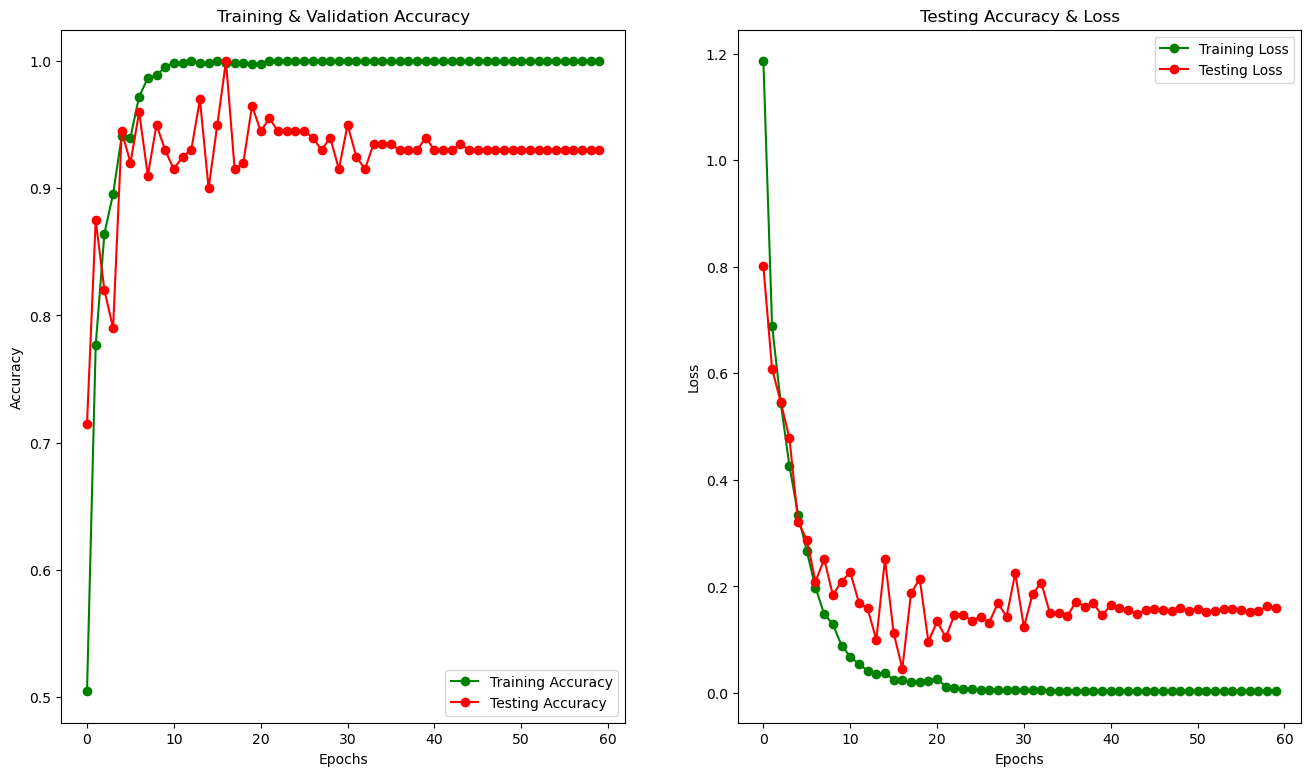

In [21]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history_GRU.history['accuracy']
train_loss = history_GRU.history['loss']
val_acc = history_GRU.history['val_accuracy']
val_loss = history_GRU.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [22]:
for var in model_GRU.trainable_weights:
    print(f"{var.name} | shape={var.shape}")
    #for v in var:
        #print(v)

gru/gru_cell/kernel:0 | shape=(18, 384)
gru/gru_cell/recurrent_kernel:0 | shape=(128, 384)
gru/gru_cell/bias:0 | shape=(2, 384)
dense_1/kernel:0 | shape=(128, 5)
dense_1/bias:0 | shape=(5,)


# LSTM модель:

In [23]:
# Инициализация модели.
model_LSTM = keras.Sequential()

# Рекуррентный слой.
model_LSTM.add(layers.LSTM(128, input_shape=(timesteps, features)))
# Выходной (предсказывающий) линейный слой.
model_LSTM.add(layers.Dense(cat_num, activation="softmax"))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               75264     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 75909 (296.52 KB)
Trainable params: 75909 (296.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Кол-во итераций обучения.
Epochs = 60

# Запустить обучение модели.
history_LSTM = model_LSTM.fit(x = X, # Признаки на которых будем предсказывать цвет.
                                y = Y, # Правильные ответы.
                                epochs = Epochs, # Кол-во итераций обучения.
                                validation_data = (X_test, Y_test), # Валидационные данные.
                                callbacks = [learning_rate_reduction])

# Сохранить модель.
model_LSTM.save('model_LSTM.h5')

Epoch 1/60
29/29 [==============================] - 1s 13ms/step - loss: 0.9120 - accuracy: 0.7100 - val_loss: 0.7244 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 2/60
29/29 [==============================] - 0s 5ms/step - loss: 0.5296 - accuracy: 0.8467 - val_loss: 0.5307 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/60
29/29 [==============================] - 0s 4ms/step - loss: 0.3813 - accuracy: 0.9133 - val_loss: 0.4159 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 4/60
29/29 [==============================] - 0s 4ms/step - loss: 0.3103 - accuracy: 0.9244 - val_loss: 0.3338 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 5/60
29/29 [==============================] - 0s 4ms/step - loss: 0.2608 - accuracy: 0.9467 - val_loss: 0.3716 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 6/60
29/29 [==============================] - 0s 4ms/step - loss: 0.2106 - accuracy: 0.9678 - val_loss: 0.3275 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 7/60
29/29 [==============================] - 0s 4ms/step - loss: 0.1715 - 

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_LSTM.evaluate(X_test, Y_test)[1]*100 , "%")

7/7 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9850
Accuracy of the model is -  98.50000143051147 %


### Анализ процесса обучения модели

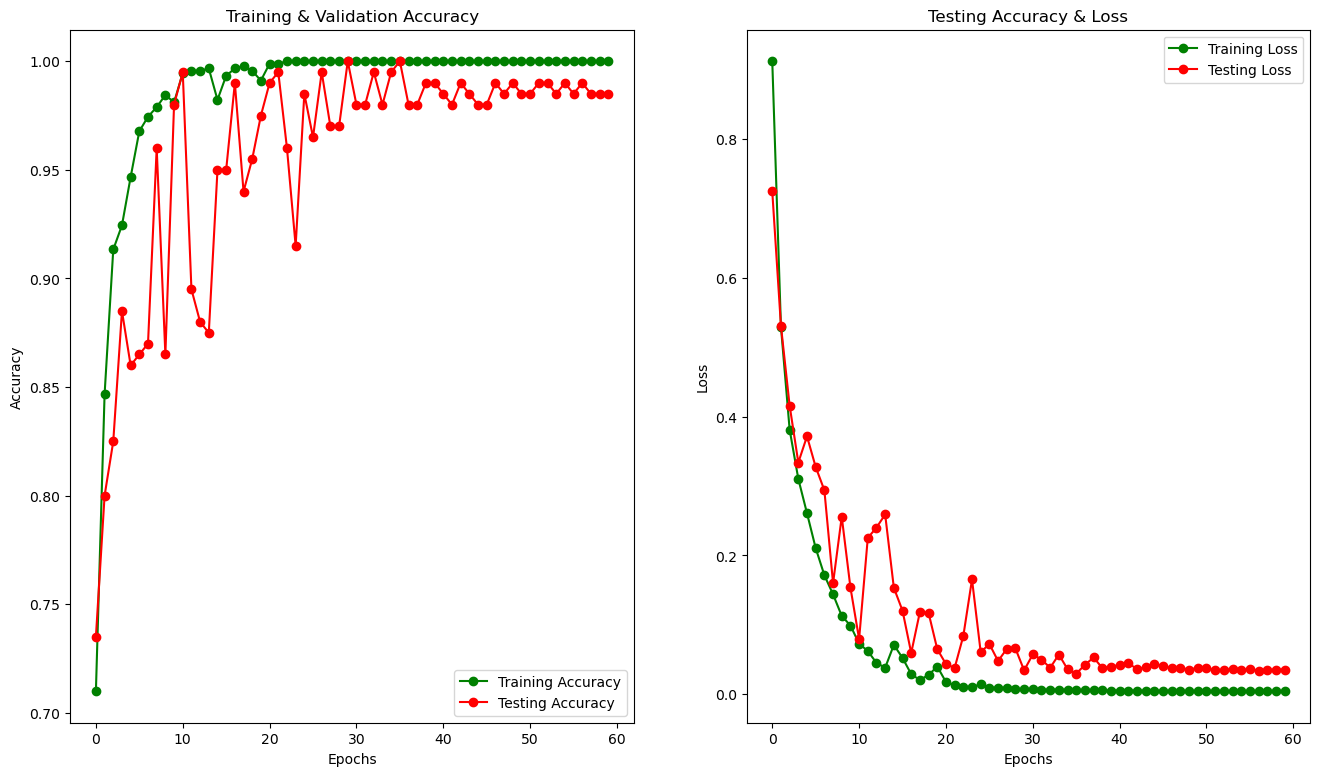

In [26]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history_LSTM.history['accuracy']
train_loss = history_LSTM.history['loss']
val_acc = history_LSTM.history['val_accuracy']
val_loss = history_LSTM.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [27]:
for var in model_LSTM.trainable_weights:
    print(f"{var.name} | shape={var.shape}")
    #for v in var:
        #print(v)

lstm/lstm_cell/kernel:0 | shape=(18, 512)
lstm/lstm_cell/recurrent_kernel:0 | shape=(128, 512)
lstm/lstm_cell/bias:0 | shape=(512,)
dense_2/kernel:0 | shape=(128, 5)
dense_2/bias:0 | shape=(5,)


# Выведим обученые веса для RNN

In [28]:
for var in model_RNN.trainable_weights:
    print(f"{var.name} | shape={var.shape}")

simple_rnn/simple_rnn_cell/kernel:0 | shape=(18, 64)
simple_rnn/simple_rnn_cell/recurrent_kernel:0 | shape=(64, 64)
simple_rnn/simple_rnn_cell/bias:0 | shape=(64,)
dense/kernel:0 | shape=(64, 5)
dense/bias:0 | shape=(5,)


In [35]:
# Число признаков на каждом временном шаге (9 динамических + 9 статических сигналов).
FEATURES = 18
# Количество скрытых нейронов в RNN.
HIDDEN = 64
# Количество выходных классов, которые модель может предсказывать.
OUTPUT = 5

# Веса которые надо выгрузить из Keras в .h файл
weights = {
    # Матрица весов, связывающая вход x_t (вектор длины FEATURES) со скрытым слоем (вектор длины HIDDEN).
    "W_x": model_RNN.layers[0].get_weights()[0],   # (18, 64)
    # Матрица весов, связывающая предыдущее скрытое состояние h_{t-1} (вектор длины HIDDEN) с текущим скрытым слоем (вектор длины HIDDEN).
    "W_h": model_RNN.layers[0].get_weights()[1],   # (64, 64)
    # Вектор Байесовского смещения, необходим для расчёта скрытого слоя (вектор длины HIDDEN).
    "b_h": model_RNN.layers[0].get_weights()[2],   # (64,)
    # Матрица весов, связывающая скрытый слой (вектор длины HIDDEN) с выходом модели (вектор длины OUTPUT).
    "W_y": model_RNN.layers[1].get_weights()[0],   # (64, 5)
    # Вектор Байесовского смещения, необходим для расчёта распределения вероятностей для всех категорий.
    "b_y": model_RNN.layers[1].get_weights()[1],   # (5,)
}

# Функция собирает строку, содержащую C-инициализацию двумерного float-массива и возвращает её как Python строку.
def to_c_array_2d(name, array):
    rows, cols = array.shape
    s = f"float {name}[{rows}][{cols}] = {{\n"
    for r in range(rows):
        row_vals = ", ".join([f"{array[r, c]:.6f}f" for c in range(cols)])
        s += f"    {{ {row_vals} }},\n"
    s += "};\n\n"
    return s

# Функция собирает строку, содержащую C-инициализацию float-вектора и возвращает её как Python строку.
def to_c_array_1d(name, array):
    size = array.shape[0]
    vals = ", ".join([f"{x:.6f}f" for x in array])
    return f"float {name}[{size}] = {{ {vals} }};\n\n"

# Записываем .h файл со всеми весами в формате для ESP32.
with open("weights.h", "w") as f:
    f.write(to_c_array_2d("W_x", weights["W_x"]))
    f.write(to_c_array_2d("W_h", weights["W_h"]))
    f.write(to_c_array_1d("b_h", weights["b_h"]))
    f.write(to_c_array_2d("W_y", weights["W_y"]))
    f.write(to_c_array_1d("b_y", weights["b_y"]))